Weight:[array([1.49333333]), array([0.04966667])]


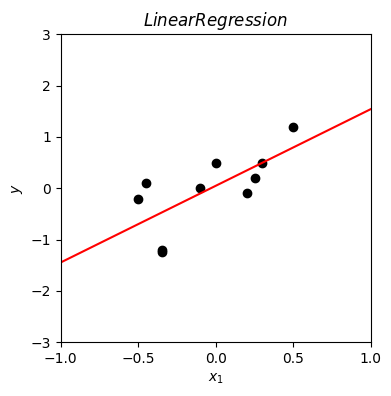

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

X = np.hstack((np.array([[-0.5,-0.45,-0.35,-0.35,-0.1,0,0.2,0.25,0.3,0.5]]).reshape(-1, 1), np.ones((10,1))*1))
y = np.array([-0.2,0.1,-1.25,-1.2,0,0.5,-0.1,0.2,0.5,1.2]).reshape(-1,1)

# 用公式求权重
w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
hat_y = X.dot(w)
print("Weight:{}".format(list(w)))

x = np.linspace(-1, 1, 50)
hat_y = x * w[0] + w[1]

plt.figure(figsize=(4,4))
plt.xlim(-1.0, 1.0)
plt.xticks(np.linspace(-1.0, 1.0, 5))
plt.ylim(-3, 3)
plt.plot(x, hat_y, color='red')
plt.scatter(X[:,0], y[:,0], color='black')
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.title('$Linear Regression$')
plt.show()

In [3]:
def KFoldCV(D, A, k):
    """
    k-fold 交叉验证
    :param D: 给定的数据集
    :param A: 学习函数
    :param k: 折数
    :return:
    """
    np.random.shuffle(D)
    dataset = np.split(D, k)
    acc_rate = 0

    for i in range(k):
        train_set = dataset.copy()
        test_set = train_set.pop(i)
        train_set = np.vstack(train_set)

        A.train(train_set[:,:-1], train_set[:,-1]) # 每次的训练集
        labels = A.fit(test_set[:,:-1]) # 每次的测试集
        acc_rate += np.mean(labels==test_set[:,-1]) # 计算平均误差

    return acc_rate/k

In [19]:
# 朴素贝叶斯
class NaiveBayes:
    def __init__(self):
        self.parameters = [] # 保存每个特征针对每个类的均值和方差
        self.y = None
        self.classes = None

    def fit(self, X, y):
        self.y = y
        self.classes = np.unique(y) # 类别

        # 计算每个特征针对每个类的均值和方差
        for i, c in enumerate(self.classes):
            # 选择类别为 c 的 X
            X_where_c = X[np.where(self.y == c)]
            self.parameters.append([])
            # 添加均值与方差
            for col in X_where_c.T:
                parameters = {"mean": col.mean(), "var": col.var()}
                self.parameters[i].append(parameters)

    def _calculate_prior(self, c):
        """先验函数"""
        frequency = np.mean(self.y == c)
        return frequency

    def _calculate_likelihood(self, mean, var, X):
        """似然函数"""
        # 高斯概率
        eps = 1e-4 # 防止除数为 0
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(X - mean, 2) / (2 * var + eps)))
        return coeff * exponent

    def _calculate_probabilities(self, X):
        posteriors = []
        for i, c in enumerate(self.classes):
            posterior = self._calculate_prior(c)

            for feature_value, params in zip(X, self.parameters[i]):
                # 独立性假设
                # P(x1,x2|Y) = P(x1|Y)*P(x2|Y)
                likelihood = self._calculate_likelihood(params["mean"], params["var"], feature_value)
                posterior *= likelihood

            posteriors.append(posterior)
        # 返回具有最大后验概率的类别
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        y_pred = [self._calculate_probabilities(sample) for sample in X]
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.sum(y == y_pred, axis=0) / len(y)
        return accuracy

In [20]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, :])

    return data[:,:-1], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train[0], y_train[0])

[4.8 3.  1.4 0.3] 0.0


In [21]:
model = NaiveBayes()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

1.0


In [22]:
# 从 sklearn 包中调用 GaussianNB 实现贝叶斯估计
from sklearn.naive_bayes import GaussianNB

skl_model = GaussianNB()
skl_model.fit(X_train, y_train)

print(skl_model.score(X_test, y_test))

1.0


In [1]:
# 逻辑回归
import numpy as np
import math
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class LogisticRegression:
    def __init__(self, learning_rate=.1):
        self.param = None
        self.learning_rate = learning_rate
        self.sigmoid = sigmoid

    def _initialize_parameters(self, X):
        n_features = np.shape(X)[1]

        # 初始化参数 theta, [-1/sqrt(N), 1/sqrt(N)]
        limit = 1 / math.sqrt(n_features)
        self.param = np.random.uniform(-limit, limit, (n_features,))

    def fit(self, X, y, n_iter=4000):
        self._initialize_parameters(X)

        # 参数theta的迭代更新
        for i in range(n_iter):
            # 求预测
            y_pred = self.sigmoid(X.dot(self.param))

            # 最小化损失函数，参数更新公式
            self.param -= self.learning_rate * -(y - y_pred).dot(X)

    def predict(self, X):
        y_pred = self.sigmoid(X.dot(self.param))
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.sum(y == y_pred, axis=0) / len(y)
        return accuracy

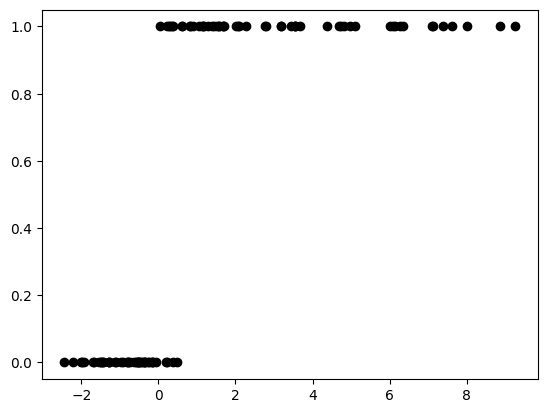

In [3]:
# 二分类问题，生成数据
n_samples = 100
np.random.seed(0)

x = np.random.normal(size=n_samples)
y = (x > 0).astype(float)
x[x > 0] *= 4
x += .3 * np.random.normal(size=n_samples)

x = x[:, np.newaxis] # 输入增加一维，用于与 theta_0 结合
plt.scatter(x, y, color='black')

In [4]:
# 训练一个逻辑回归模型
model = LogisticRegression()
model.fit(x, y)

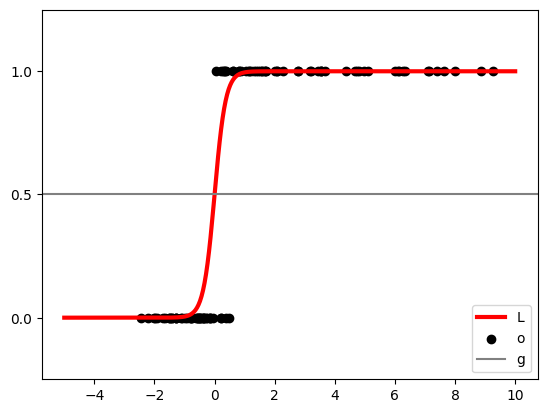

In [5]:
# 预测
x_test = np.linspace(-5, 10, 300)
x_test = x_test[:, np.newaxis]
prob = model.predict(x_test).ravel()

plt.plot(x_test, prob, color='red', linewidth=3)
plt.scatter(x, y, color='black')
plt.axhline(0.5, color='0.5')
plt.ylim(-0.25, 1.25)
plt.yticks([0, 0.5, 1])
plt.legend(('Logistic Regression Model'), loc='lower right')

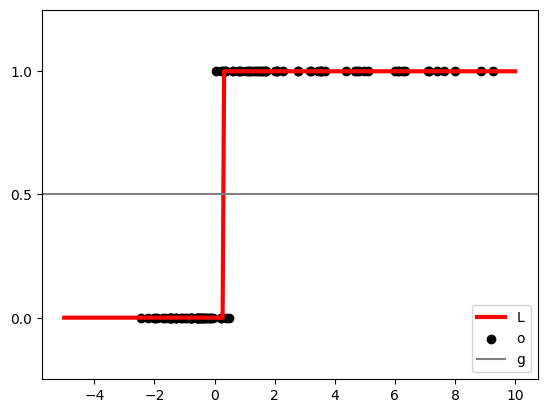

In [6]:
# 使用sklearn实现逻辑回归
from sklearn.linear_model import LogisticRegression

# C 表示正则化系数的倒数，solver 表示优化算法选择参数
skl_model = LogisticRegression()
skl_model.fit(x, y)

# 预测
x_test = np.linspace(-5, 10, 300)
x_test = x_test[:, np.newaxis]
prob = skl_model.predict(x_test).ravel()

plt.plot(x_test, prob, color='red', linewidth=3)
plt.scatter(x, y, color='black')
plt.axhline(0.5, color='0.5')
plt.ylim(-0.25, 1.25)
plt.yticks([0, 0.5, 1])
plt.legend(('Logistic Regression Model'), loc='lower right')

In [10]:
# 用自定义逻辑回归，iris 数据集测试
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, :])
    return data[:,:-1], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train[0], y_train[0])

[5.7 3.8 1.7 0.3] 0.0


In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)

# 测试数据
print(model.score(X_test, y_test))

1.0


In [12]:
# 从 sklearn 包中调用 LogisticRegression 测试
from sklearn.linear_model import LogisticRegression
skl_model = LogisticRegression()
skl_model.fit(X_train, y_train)

# 测试数据
print(skl_model.score(X_test, y_test))

1.0
